In [17]:
# manipulation des données
import numpy as np
import pandas as pd

# matplotlib et seaborn pour les représentations graphiques
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# sklearn preprocessing pour le traiter les variables catégorielles
from sklearn.preprocessing import LabelEncoder

# Gestion du système de fichiers
import os

# Suppression des alertes
import warnings
warnings.filterwarnings('ignore')

In [18]:
df = pd.read_csv("../Data/1.normalized_dataset_completed.csv")

In [19]:
import ast

array_list = df['description_token'].values
data_list = []
for item in array_list:
    data_list.append(ast.literal_eval(item))

df['description_token'] = data_list
df

,product_name,product_category_tree,description,description_token,words
0,Elegance Polyester Multicolor Abstract Eyelet ...,Home Furnishing,Key Features of Elegance Polyester Multicolor ...,"[key, feature, elegance, polyester, multicolor...",key feature elegance polyester multicolor abst...
1,Sathiyas Cotton Bath Towel,Baby Care,Specifications of Sathiyas Cotton Bath Towel (...,"[specification, sathiyas, cotton, bath, towel,...",specification sathiyas cotton bath towel bath...
2,Eurospa Cotton Terry Face Towel Set,Baby Care,Key Features of Eurospa Cotton Terry Face Towe...,"[key, feature, eurospa, cotton, terry, face, t...",key feature eurospa cotton terry face towel se...
3,SANTOSH ROYAL FASHION Cotton Printed King size...,Home Furnishing,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[key, feature, santosh, royal, fashion, cotton...",key feature santosh royal fashion cotton print...
4,Jaipur Print Cotton Floral King sized Double B...,Home Furnishing,Key Features of Jaipur Print Cotton Floral Kin...,"[key, feature, jaipur, print, cotton, floral, ...",key feature jaipur print cotton floral king si...
...,...,...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,Baby Care,Oren Empower Extra Large Self Adhesive Sticker...,"[oren, empower, extra, large, self, adhesive, ...",oren empower extra large self adhesive sticker...
1046,Wallmantra Large Vinyl Sticker Sticker,Baby Care,Wallmantra Large Vinyl Sticker Sticker (Pack o...,"[wallmantra, large, vinyl, sticker, sticker, p...",wallmantra large vinyl sticker sticker pack p...
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,Baby Care,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,"[buy, uberlyfe, extra, large, pigment, polyvin...",buy uberlyfe extra large pigment polyvinyl fil...
1048,Wallmantra Medium Vinyl Sticker Sticker,Baby Care,Buy Wallmantra Medium Vinyl Sticker Sticker fo...,"[buy, wallmantra, medium, vinyl, sticker, stic...",buy wallmantra medium vinyl sticker sticker r ...


In [20]:
df['cluster'] = 0
df.loc[df['product_category_tree'] == 'Home Furnishing', 'cluster'] = 0
df.loc[df['product_category_tree'] == 'Baby Care', 'cluster'] = 1
df.loc[df['product_category_tree'] == 'Watches', 'cluster'] = 2
df.loc[df['product_category_tree'] == 'Home Decor & Festive Needs', 'cluster'] = 3
df.loc[df['product_category_tree'] == 'Kitchen & Dining', 'cluster'] = 4
df.loc[df['product_category_tree'] == 'Beauty and Personal Care', 'cluster'] = 5
df.loc[df['product_category_tree'] == 'Computers', 'cluster'] = 6

In [21]:
l_cat = list(set(df['product_category_tree']))
print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(df.iloc[i]['product_category_tree'])) for i in range(len(df))]

catégories :  ['Kitchen & Dining', 'Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Watches']


In [22]:
from nltk.tokenize import word_tokenize

df['words'] = df['words'].astype(str)
for i in range(len(df['words'])):
    tokenize_description = word_tokenize(df['words'][i])
    df['description_token'][i] = tokenize_description

In [23]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [24]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.15.0
2.15.0
Num GPUs Available:  0
False


In [25]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [26]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)
sentences = df['words'].to_list()

loading configuration file config.json from cache at /Users/gaeldelescluse/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.36.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file model.safetensors from cache at /Users/gaeldelescluse/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf876516699

In [27]:
# Création des features
import time

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, max_length, batch_size, mode='HF')

loading configuration file config.json from cache at /Users/gaeldelescluse/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8a40076/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.36.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /Users/gaeldelescluse/.cache/huggingface/hub/models--bert-base-uncased/snapshots/1dbc166cf8765166998eff31ade2eb64c8

1/1 [==============================] - 1s 660ms/step
temps traitement :  89.0


In [28]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(features_bert)

df_tsne = pd.DataFrame({"tsne_1" : X_tsne[:, 0], "tsne_2" : X_tsne[:, 1], "cluster" : df['cluster']})

In [29]:
from sklearn import cluster

X = df_tsne.drop('cluster', axis=1).values
kmeans = cluster.KMeans(n_clusters=7, n_init=100, random_state=42)
df_tsne['cluster_predict'] = kmeans.fit_predict(X)

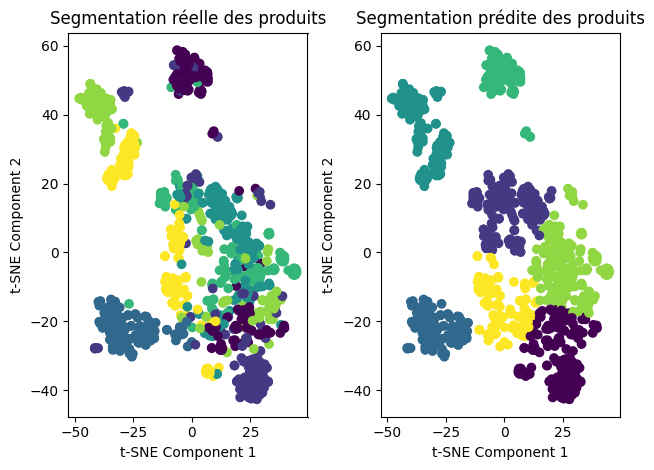

In [30]:
plt.subplot(1, 2, 1)
plt.scatter(df_tsne['tsne_1'], df_tsne['tsne_2'], c=df_tsne['cluster'], cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Segmentation réelle des produits')

plt.subplot(1, 2, 2)
plt.scatter(df_tsne['tsne_1'], df_tsne['tsne_2'], c=df_tsne['cluster_predict'], cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Segmentation prédite des produits')

plt.tight_layout()
plt.show()

In [31]:
from sklearn import metrics
ARI = np.round(metrics.adjusted_rand_score(df_tsne['cluster'], kmeans.labels_),4)
ARI

0.3374